In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import sys
sys.path.append("../src/")

In [15]:
from util.dataGeneration.writer_13753_04 import Writer13753_04

writer = Writer13753_04(num_cerfa="13753_04")

In [16]:
writer

In [17]:
writer.fill_form()

In [18]:
writer.annotator.dic

{'Rect(260.1700134277344, 54.28802490234375, 270.1700134277344, 64.28802490234375)': ('topmostSubform[0].Page1[0].Groupe_de_boutons_radio[0]',
  True),
 'Rect(287.03900146484375, 201.42999267578125, 296.03900146484375, 210.42999267578125)': ('topmostSubform[0].Page1[0].Groupe_de_boutons_radio[1]',
  True),
 'Rect(226.42599487304688, 202.19000244140625, 235.42599487304688, 211.19000244140625)': ('topmostSubform[0].Page1[0].Groupe_de_boutons_radio[2]',
  True),
 'Rect(94.285113515543, 217.62078730543465, 380.5248916724453, 229.0512708000341)': ('topmostSubform[0].Page1[0].txtNoms[0]',
  'Agathe Launay'),
 'Rect(397.17762075486667, 217.11598833206511, 563.7133704560708, 229.55606977340364)': ('topmostSubform[0].Page1[0].numSIRET[0]',
  '20022300600335'),
 'Rect(177.72013948113758, 248.0179752958175, 550.6528463587061, 259.653045211995)': ('topmostSubform[0].Page1[0].txtCommune[0]',
  'GuilletBourg'),
 'Rect(207.15038980972693, 279.49841961905304, 272.77662740218716, 291.6376277442282)': (

On part de ce dictionnaire et on normalise les coordonnées, puis on match avec l'extraction OCR. Pour chacune des coordonnées, on récupère toutes les bb OCR avec intersection non nulle, puis on clean et ça nous donne l'extraction

1) Plot OCR

In [19]:
import fitz
from PIL import Image

In [20]:
def read_pdf_as_image(pdf_path: str):
    doc = fitz.open(pdf_path)
    page = doc.load_page(0)
    pix = page.get_pixmap()

    mode = "RGB"
    image = Image.frombytes(mode, [pix.width, pix.height], pix.samples)
    return image

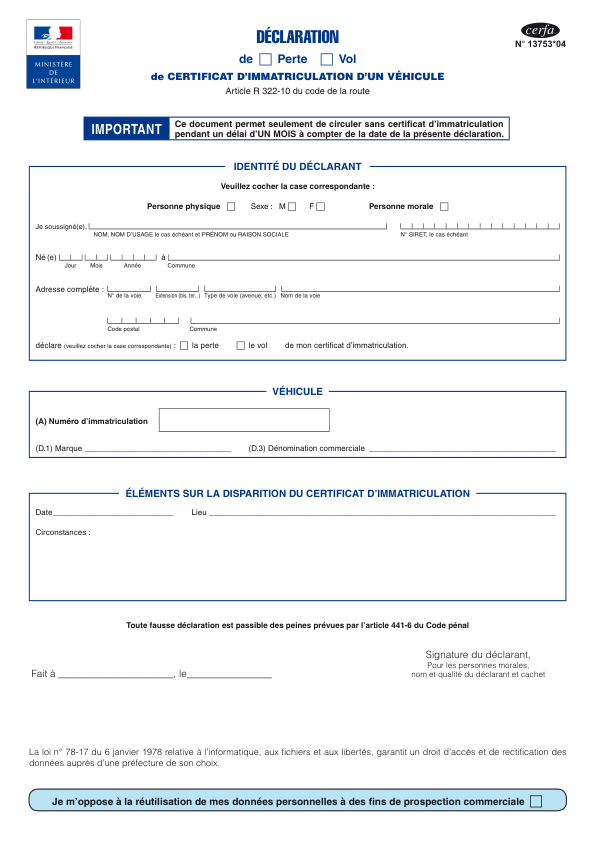

In [21]:
read_pdf_as_image("../data/empty_forms/editable/cerfa_13753_04.pdf")

In [27]:
from PIL import ImageDraw
import re

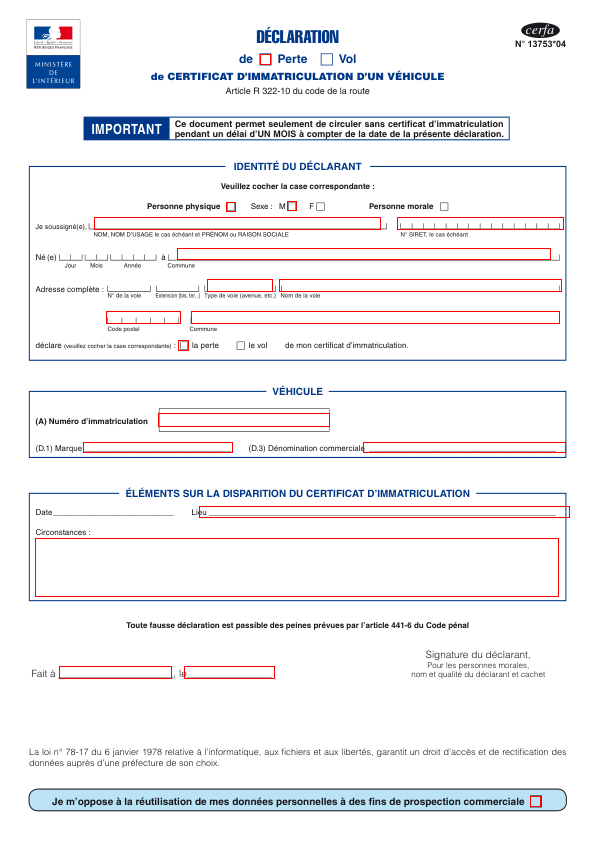

In [28]:
image = read_pdf_as_image("../data/empty_forms/editable/cerfa_13753_04.pdf")
draw = ImageDraw.Draw(image)

for box, field in writer.annotator.dic.items():
    pattern = r"[-+]?\d*\.\d+|[-+]?\d+"
    numbers = [float(match) for match in re.findall(pattern, box)]
    if len(numbers) == 4:
        x0, y0, x1, y1 = numbers
    else:
        raise ValueError("Could not get coordinates of bounding box.")

    field_name, field_value = field
    positions_to_plot = [(x0, y0), (x1, y0), (x1, y1), (x0, y1), (x0, y0)]
    draw.line(xy=positions_to_plot, fill="red")

image.show()

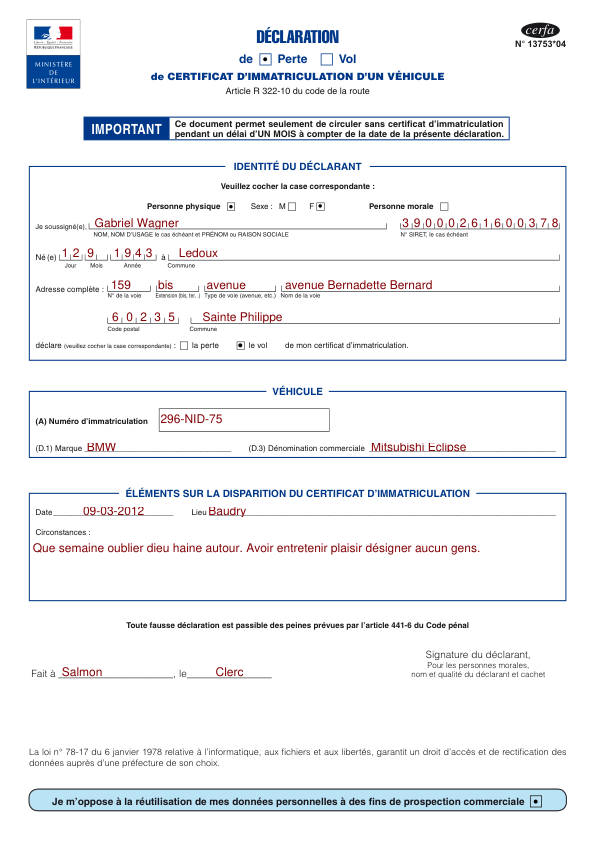

In [29]:
read_pdf_as_image("../output/13753_04/cerfa_13753_04_v8023326ebc7b40209f2e41d19c9f65ca.pdf")

OCR de cet exemplaire du formulaire.

In [31]:
from models.classify_form.doctr.identify_cerfa_doctr import get_list_words_in_page, DoctrTransformer

In [33]:
from pathlib import Path

In [114]:
transformer = DoctrTransformer()

path = "../output/13753_04/cerfa_13753_04_v8023326ebc7b40209f2e41d19c9f65ca.pdf"
doc = fitz.open(path)
# If text is available directly
page = doc.load_page(0)

doctr_documents = transformer.transform([Path(path)])

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Could not analyze document ../output/13753_04/cerfa_13753_04_v8023326ebc7b40209f2e41d19c9f65ca.pdf. Error: unable to read file.


In [36]:
from doctr.io import Document, DocumentFile
doc_doctr = DocumentFile.from_pdf(path)

In [39]:
from doctr.models import ocr_predictor

doctr_model = ocr_predictor(
    det_arch="db_resnet50",
    reco_arch="crnn_vgg16_bn",
    pretrained=True,
)
output = doctr_model(doc_doctr)

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/mamba/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and

In [71]:
def process_doctr_output(doctr_output, width, height):
    processed_output = {}

    page = doctr_output.pages[0]  # docs à une page
    list_words_in_page = get_list_words_in_page(page)

    for word in list_words_in_page:
        label = word.value
        x0, y0 = word.geometry[0][0] * width, word.geometry[0][1] * height
        x1, y1 =  word.geometry[1][0] * width,  word.geometry[1][1] * height

        processed_output[(x0, y0, x1, y1)] = label

    return processed_output

In [67]:
path = "../output/13753_04/cerfa_13753_04_v8023326ebc7b40209f2e41d19c9f65ca.pdf"
image = read_pdf_as_image(path)
width, height = image.size

In [72]:
processed_output = process_doctr_output(output, width, height)

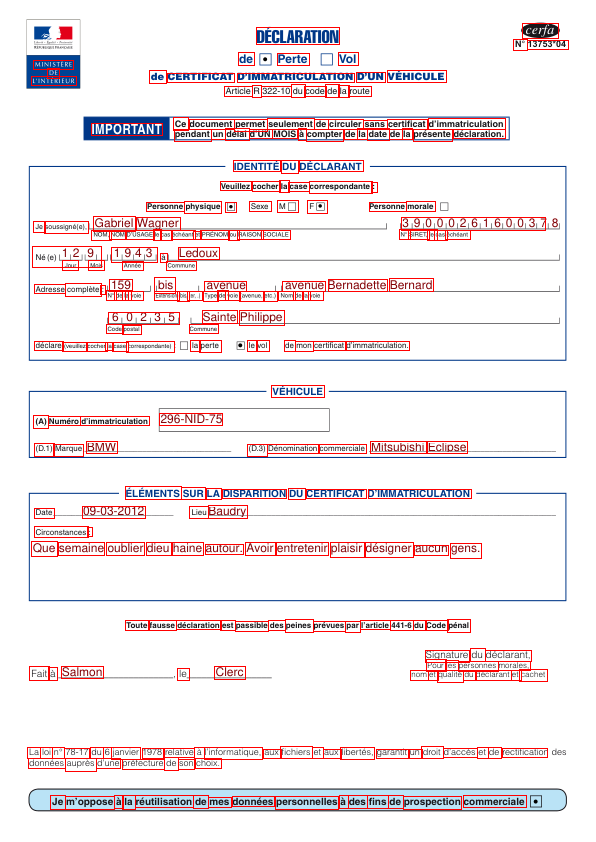

In [73]:
image = read_pdf_as_image(path)
draw = ImageDraw.Draw(image)

for box, word in processed_output.items():
    x0, y0, x1, y1 = box
    positions_to_plot = [(x0, y0), (x1, y0), (x1, y1), (x0, y1), (x0, y0)]
    draw.line(xy=positions_to_plot, fill="red")

image.show()

First simple algorithm, for each OCR bb, compute intersection with all interest bbs, and match with the one with the greatest intersection area if the latter is more than x% of the OCR bb area.

In [78]:
from typing import Dict, Tuple

In [93]:
def compute_box_area(box: Tuple):
    x0, y0, x1, y1 = box
    box_width = x1 - x0
    box_height = y1 - y0
    box_area = box_width * box_height
    return box_area

In [94]:
def compute_boxes_intersection(box1, box2):
    x0_1, y0_1, x1_1, y1_1 = box1
    x0_2, y0_2, x1_2, y1_2 = box2
    
    # Calculate the coordinates of the intersection box
    x0_intersection = max(x0_1, x0_2)
    y0_intersection = max(y0_1, y0_2)
    x1_intersection = min(x1_1, x1_2)
    y1_intersection = min(y1_1, y1_2)
    
    # Check if the intersection box is valid
    if x0_intersection <= x1_intersection and y0_intersection <= y1_intersection:
        return (x0_intersection, y0_intersection, x1_intersection, y1_intersection)
    else:
        return None  # No intersection

In [103]:
def clean_cerfa_template(cerfa_template: Dict):
    clean_template = {}
    # For now cerfa template is the raw writer's annotator dict
    for box, field in cerfa_template.items():
        pattern = r"[-+]?\d*\.\d+|[-+]?\d+"
        numbers = [float(match) for match in re.findall(pattern, box)]
        if len(numbers) == 4:
            x0, y0, x1, y1 = numbers
        else:
            raise ValueError("Could not get coordinates of bounding box.")

        field_name, _ = field
        clean_template[field_name] = (x0, y0, x1, y1)
    return clean_template

In [108]:
def match_bounding_boxes_to_template(
    ocr_bounding_boxes: Dict,
    clean_cerfa_template: Dict,
    area_ratio_threshold: float
):
    filled_template = {key: [] for key in clean_cerfa_template.keys()}
    matched_boxes = {key: [] for key in clean_cerfa_template.keys()}
    for ocr_box, word in ocr_bounding_boxes.items():
        box_area = compute_box_area(ocr_box)
        field_to_increment = None
        max_intersection_area = 0
        for field_name, template_box in clean_cerfa_template.items():
            intersection = compute_boxes_intersection(ocr_box, template_box)
            if intersection is not None:
                intersection_area = compute_box_area(intersection)
                if (intersection_area / box_area > area_ratio_threshold) and (intersection_area > max_intersection_area):
                    max_intersection_area = intersection_area
                    field_to_increment = field_name
        if field_to_increment:
            filled_template[field_to_increment].append(word)
            matched_boxes[field_to_increment].append(ocr_box)
            
    filled_str_template = {key: " ".join(value) for key, value in filled_template.items()}
    return filled_str_template, matched_boxes


In [102]:
match_bounding_boxes_to_template(
    processed_output,
    clean_cerfa_template(writer.annotator.dic),
    0.5
)

({'topmostSubform[0].Page1[0].Groupe_de_boutons_radio[0]': '',
  'topmostSubform[0].Page1[0].Groupe_de_boutons_radio[1]': '',
  'topmostSubform[0].Page1[0].Groupe_de_boutons_radio[2]': 'la',
  'topmostSubform[0].Page1[0].txtNoms[0]': 'Gabriel Wagner',
  'topmostSubform[0].Page1[0].numSIRET[0]': '39,0,0,0,2,6,1,6,0,0,37',
  'topmostSubform[0].Page1[0].txtCommune[0]': 'Ledoux',
  'topmostSubform[0].Page1[0].txtTypeVoie[0]': 'avenue',
  'topmostSubform[0].Page1[0].tktNomVoie[0]': 'avenue Bernadette Bernard',
  'topmostSubform[0].Page1[0].numCP[0]': '6,0,2,3,5',
  'topmostSubform[0].Page1[0].txtCommune[1]': 'Sainte Philippe',
  'topmostSubform[0].Page1[0].Groupe_de_boutons_radio[3]': '',
  'topmostSubform[0].Page1[0].txtImmatriculation[0]': '296-NID-75',
  'topmostSubform[0].Page1[0].txtMarque[0]': 'BMW',
  'topmostSubform[0].Page1[0].txtDenomination[0]': 'Mitsubishi Eclipse',
  'topmostSubform[0].Page1[0].txtLieuDisporation[0]': 'Baudry',
  'topmostSubform[0].Page1[0].txtCirconstances[0]'

In [111]:
def plot_matched_boxes(
    image: Image,
    clean_cerfa_template: Dict,
    matched_boxes: Dict,
):
    draw = ImageDraw.Draw(image)

    for field_name, template_box in clean_cerfa_template.items():
        ocr_boxes = matched_boxes[field_name]
        if len(ocr_boxes) > 0:
            x0, y0, x1, y1 = template_box
            positions_to_plot = [(x0, y0), (x1, y0), (x1, y1), (x0, y1), (x0, y0)]
            draw.line(xy=positions_to_plot, fill="red")
            for ocr_box in ocr_boxes:
                x0, y0, x1, y1 = ocr_box
                positions_to_plot = [(x0, y0), (x1, y0), (x1, y1), (x0, y1), (x0, y0)]
                draw.line(xy=positions_to_plot, fill="blue")
    image.show()

In [109]:
filled_str_template, matched_boxes = match_bounding_boxes_to_template(
    processed_output,
    clean_cerfa_template(writer.annotator.dic),
    0.5
)

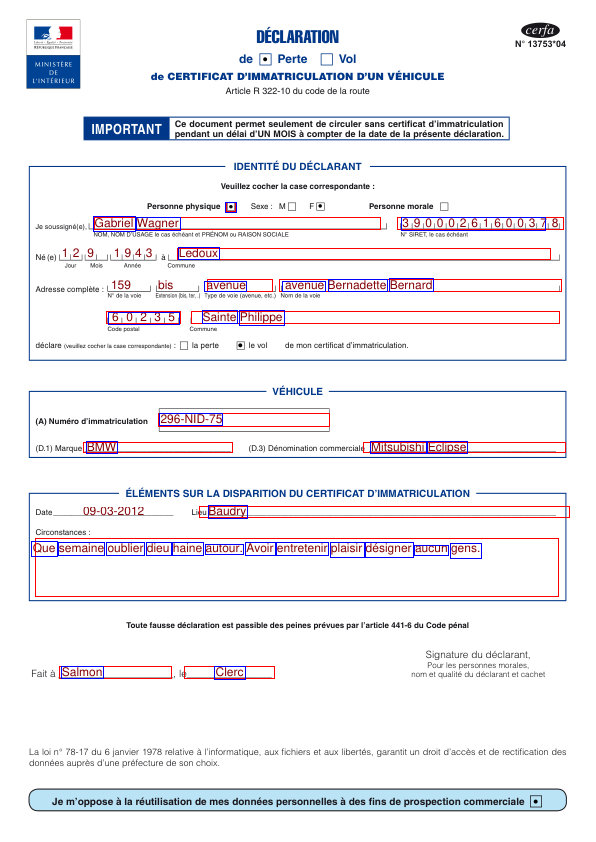

In [113]:
image = read_pdf_as_image(path)

clean_template = clean_cerfa_template(writer.annotator.dic)
plot_matched_boxes(image, clean_cerfa_template=clean_template, matched_boxes=matched_boxes)